In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df1 = pd.read_csv("dataset/train.tsv", sep="\t")
df1.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df1.shape

(156060, 4)

In [4]:
df1.drop_duplicates(subset="SentenceId", keep="first", inplace=True)
df1.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [5]:
df1.shape

(8529, 4)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8529 entries, 0 to 156039
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    8529 non-null   int64 
 1   SentenceId  8529 non-null   int64 
 2   Phrase      8529 non-null   object
 3   Sentiment   8529 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 333.2+ KB


In [7]:
df1["Sentiment"].value_counts()

3    2321
1    2200
2    1655
4    1281
0    1072
Name: Sentiment, dtype: int64

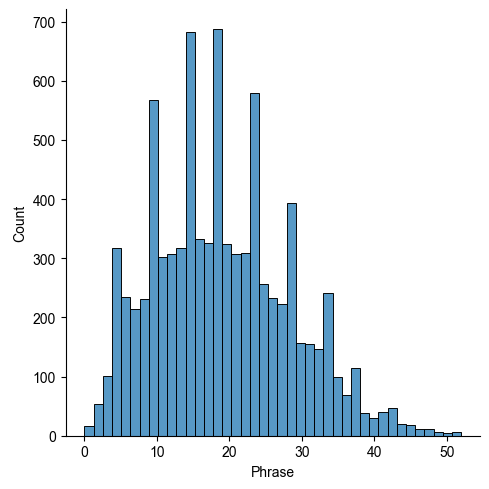

<Figure size 10000x2500 with 0 Axes>

In [8]:
sns.displot(df1["Phrase"].apply(lambda x: len(x.split())))

sns.set_style("darkgrid")
plt.figure(figsize=(100,25))
plt.show()

In [9]:
SEQ_LEN = 50
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

C:\Users\ganes\anaconda3\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ganes\anaconda3\envs\project\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ganes\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this ar

In [10]:
Xids = np.zeros((len(df1), SEQ_LEN))
Xmask = np.zeros((len(df1), SEQ_LEN))

Xids.shape, Xmask.shape

((8529, 50), (8529, 50))

In [11]:
for i, sequence in enumerate(df1["Phrase"]):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    Xids[i, :], Xmask[i, :] = tokens["input_ids"], tokens["attention_mask"]

In [12]:
lbl_arr = df1["Sentiment"].values
final_labels = np.zeros((lbl_arr.size, lbl_arr.max()+1))

final_labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [13]:
final_labels[np.arange(lbl_arr.size), lbl_arr] = 1
final_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [14]:
with open("dataset/bertDataset.npz", "wb") as f:
    np.savez(f, Xids = Xids, Xmask = Xmask, labels = final_labels)

In [15]:
del Xids, Xmask, final_labels, df1

In [16]:
with open("dataset/bertDataset.npz", "rb") as f:
    data = np.load(f)
    
    Xids = data["Xids"]
    Xmask = data["Xmask"]
    labels = data["labels"]

In [17]:
Xids.shape, Xmask.shape, labels.shape

((8529, 50), (8529, 50), (8529, 5))

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [19]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [20]:
dataset = dataset.map(map_func)

for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  1326.,  1104., 13936., 25265., 16913., 15107.,
        1103.,  8050.,  2553.,  1115.,  1184.,  1110.,  1363.,  1111.,
        1103., 20398.,  1110.,  1145.,  1363.,  1111.,  1103.,   176.,
        9900.,   117.,  1199.,  1104.,  1134.,  5411.,  1821., 14225.,
        1133.,  3839.,  1104.,  1134.,  7919.,  1106.,  1277.,  1104.,
         170.,  1642.,   119.,   102.,     0.,     0.,     0.,     0.,
           0.,     0.])>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])>}, <tf.Tensor: shape=(5,), dtype=float64, numpy=array([0., 1., 0., 0., 0.])>)


In [21]:
dataset = dataset.shuffle(1000000).batch(32)

In [22]:
DS_LEN = len(dataset)

In [23]:
SPLIT = 0.9

train_data = dataset.take(round(DS_LEN * SPLIT))
val_data = dataset.skip(round(DS_LEN * SPLIT))

del dataset

In [24]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN, ), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(SEQ_LEN, ), name="attention_mask", dtype="int32")

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation="relu")(X)
X = tf.keras.layers.Dense(128, activation="relu")(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(64, activation="relu")(X)
X = tf.keras.layers.Dense(32, activation="relu")(X)

y = tf.keras.layers.Dense(5, activation="softmax",  name="outputs")(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

In [26]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]   

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=8),
            tf.keras.callbacks.ModelCheckpoint("bert_model.h5",verbose= 1 ,save_best_only=True)]

optimizer = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
history = model.fit(train_data, 
                   validation_data=val_data,
                   epochs=200,
                   callbacks=callbacks
                   )

Epoch 1/200
240/240 [==============================] - ETA: 0s - loss: 1.4444 - accuracy: 0.3569
Epoch 00001: val_loss improved from inf to 1.29720, saving model to bert_model.h5
240/240 [==============================] - 660s 3s/step - loss: 1.4444 - accuracy: 0.3569 - val_loss: 1.2972 - val_accuracy: 0.4264
Epoch 2/200
240/240 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.4294
Epoch 00002: val_loss improved from 1.29720 to 1.22915, saving model to bert_model.h5
240/240 [==============================] - 678s 3s/step - loss: 1.3075 - accuracy: 0.4294 - val_loss: 1.2292 - val_accuracy: 0.4888
Epoch 3/200
240/240 [==============================] - ETA: 0s - loss: 1.2798 - accuracy: 0.4495
Epoch 00003: val_loss improved from 1.22915 to 1.16856, saving model to bert_model.h5
240/240 [==============================] - 681s 3s/step - loss: 1.2798 - accuracy: 0.4495 - val_loss: 1.1686 - val_accuracy: 0.4865
Epoch 4/200
240/240 [==============================] - ETA:

Epoch 28/200
240/240 [==============================] - ETA: 0s - loss: 0.9202 - accuracy: 0.6191
Epoch 00028: val_loss improved from 0.60010 to 0.56571, saving model to bert_model.h5
240/240 [==============================] - 593s 2s/step - loss: 0.9202 - accuracy: 0.6191 - val_loss: 0.5657 - val_accuracy: 0.8139
Epoch 29/200
240/240 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6314
Epoch 00029: val_loss improved from 0.56571 to 0.55613, saving model to bert_model.h5
240/240 [==============================] - 670s 3s/step - loss: 0.9010 - accuracy: 0.6314 - val_loss: 0.5561 - val_accuracy: 0.8068
Epoch 30/200
240/240 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6280
Epoch 00030: val_loss improved from 0.55613 to 0.52732, saving model to bert_model.h5
240/240 [==============================] - 585s 2s/step - loss: 0.9018 - accuracy: 0.6280 - val_loss: 0.5273 - val_accuracy: 0.8245
Epoch 31/200
240/240 [==============================

In [ ]:
hist = history
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
def map_to_input(sen:str, seq_len:int):
    tokens = tokenizer.encode_plus(sen, max_length=seq_len, 
                               truncation=True, padding="max_length",
                               add_special_tokens=True, return_token_type_ids=False,
                               return_attention_mask=True, return_tensors="tf"
                              )
    
    return tokens

In [ ]:
from transformers import TFBertModel

# Define the custom objects dictionary with the TFBertModel layer
custom_objects = {'TFBertModel': TFBertModel}

# Load the model and pass the custom objects dictionary
model = tf.keras.models.load_model('bert_model.h5', custom_objects=custom_objects)

In [ ]:
classes = {
    0: "Negative",
    1: "Somewhat Negative",
    2: "Neutral",
    3: "Somewhat Positive",
    4: "Positive"
}

In [ ]:
df2 = pd.read_csv("dataset/test.tsv", sep="\t")
df2.drop_duplicates(subset="SentenceId", keep="first", inplace=True)
df2.head()

In [ ]:
final_out = {}

for i in tqdm(range(100)):
    to_test = df2["Phrase"].iloc[i]
#     print(to_test)

    test_input = map_to_input(to_test, SEQ_LEN)
    input_ids = test_input["input_ids"]
    mask = test_input["attention_mask"]
    
    pred = model.predict([input_ids, mask], verbose=0)
#     print(f"The output class is: {classes[np.argmax(pred[0])]}")
    final_out[to_test] = classes[np.argmax(pred[0])]

In [ ]:
for i in final_out.keys():
    print(f"{i[:100]} ==> {final_out[i]}\n")